# Intravoxel incoherent motion (IVIM) imaging

Intra-voxel incoherent motion (IVIM) is a 2-compartment model that separates diffusion signal contributions originating from blood flow and Brownian diffusion *(Le Bihan et al. 1988)*. The model consists of 2 Ball compartments (isotropic Gaussian), each fitting the blood flow and diffusion volume fractions and diffusivities, respectively. Changes in e.g. blood volume fraction has been linked to many pathologies such as the vasculature in tumor tissue *(Le Bihan 2018)*.

\begin{align}
 E_{\textrm{IVIM}}= \underbrace{f_{\textrm{blood}}\overbrace{E_{\textrm{iso}}(\lambda_{\textrm{Blood}})}^{\textrm{Ball}}}_{\textrm{Blood}} + \underbrace{f_{\textrm{Diffusion}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{Diffusion}})}^{\textrm{Ball}}}_{\textrm{Diffusion}}
\end{align}

Because the apparent diffusivity of blood flow is much higher than that of Brownian motion, the optimization bounds for the diffusivities of the two Balls are disjoint; the diffusivies of the diffusion compartment range
between [0.5 - 6]e-3 $mm^2/s$ (results in more precise fit according to *(Gurney-Champion et al. 2016)*), and those of the blood compartment range between [6 - 20]e-3 $mm^2/s$ (following *(Park et al. 2017)*). 

The separability of blood and diffusion signal hinges on the observation that the blood-flow signal is negligible at b-values above 200-400 s/mm^2, but it does have a constribution below that bvalue (and to the b0).
    
Many different optimization strategies have been proposed to fit the IVIM model *(Wong et al. 2018, Gurney-Champion et al. 2018)*, of which in this example we will use Dmipy to implement and fit two:
- Following *(Wong et al. 2018)*, a two-step optimization based on the approach that first fits the 'diffusion' diffusivity by fitting a single Ball compartment to the signal where all b-values below b=400$s/mm^2$ have been truncated. Fixing this initial diffusivity, the 2-compartment model is then fitted to the whole signal.
- Following *(Gurney-Champion et al. 2018)*, they found simply fixing $\lambda_{blood}=7e-9 mm^2/s$ results in the second-best IVIM fitting performance (after fancy Bayesian fitting).

We compare our implemented IVIM algorithms with the one available in Dipy, and evaluate/compare the fitted parameter maps and fitting errors.

## Implementing 2-step IVIM using Dmipy
The 2-step fitting approach used in e.g. *(Wong et al. 2018)* consists of two steps:
- step 1: fit only the "diffusion" part of the data using a single Ball compartment, so the data is truncated to only include measurements above the bvalue_threshold value. This step estimates the "diffusion" S0 (which is lower or equal to the actual SO) and the "diffusion" diffusivity of this compartment.
- step 2: fit the 2-compartment model to the whole signal, but fixing the "diffusion" diffusivity to the value estimated in step 1.

We'll use the same example dataset and acquisition scheme that Dipy uses as well:

### Load IVIM acquisition scheme and data

In [13]:
from dipy.data.fetcher import read_ivim
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy, acquisition_scheme_from_bvalues
img, gtab = read_ivim()
scheme_ivim = gtab_dipy2dmipy(gtab, b0_threshold=1e6, min_b_shell_distance=1e6)
scheme_ivim.print_acquisition_info

data = img.get_data()
data_slice = data[90: 155, 90: 170, 33, :]
test_voxel = data_slice[0, 0]

Dataset is already in place. If you want to fetch it again please first remove the folder /home/rutger/.dipy/ivim 
Acquisition scheme summary

total number of measurements: 21
number of b0 measurements: 1
number of DWI shells: 20

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |1         |10              |N/A                      |N/A        |N/A       |N/A  
2           |1         |20              |N/A                      |N/A        |N/A       |N/A  
3           |1         |30              |N/A                      |N/A        |N/A       |N/A  
4           |1         |40              |N/A                      |N/A        |N/A       |N/A  
5           |1         |60              |N/A                      |N/A        |N/A       |N/A  
6           |1         |80              |N/A                      |N/A        |N/A       |N/A  


Notice that this scheme has 1 b-value per "shell" for different b-values.

### Step 1: Fit only Diffusion model using higher b-value data

The first step is to truncate the data below a lower b-value threshold and fit a single-compartment Ball model to estimate the "diffusion" signal diffusivity.

Note that to do this we need to estimate the S0 intensity of the signal without having any b0-measurements. This is handled internally by dmipy by fitting a Gaussian to the available data points and extrapolating the b0.

In [14]:
bvalue_threshold = 4e8  # s/m^2 lower threshold b-value
bvalue_mask = scheme_ivim.bvalues > bvalue_threshold
gaussian_acquisition_scheme = acquisition_scheme_from_bvalues(
    bvalues=scheme_ivim.bvalues[bvalue_mask],
    gradient_directions=scheme_ivim.gradient_directions[
        bvalue_mask])
gaussian_data = test_voxel[bvalue_mask]

Note that we must set `optimize_S0=True` here to explicity estimate it.

In [15]:
from dmipy.signal_models.gaussian_models import G1Ball
from dmipy.core.modeling_framework import MultiCompartmentModel

gaussian_mod = MultiCompartmentModel([G1Ball()])
gaussian_mod.set_parameter_optimization_bounds(
    'G1Ball_1_lambda_iso', [0.5e-9, 6e-9])  # optimization range according to Gurney-Champion 2016
gaussian_fit = gaussian_mod.fit(
    acquisition_scheme=gaussian_acquisition_scheme,
    data=gaussian_data,
    optimize_S0=True)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.00290489196777 seconds
Fitting of 1 voxels complete in 0.0232429504395 seconds.
Average of 0.0232429504395 seconds per voxel.


### Step 2: Fit whole signal with 2-compartment IVIM model (D fixed from step 1)

The second step is done by fixing the diffusion diffusivity in the 2-compartment Ball model and fitting the entire signal.

In [16]:
ivim_mod = MultiCompartmentModel([G1Ball(), G1Ball()])
ivim_mod.set_parameter_optimization_bounds(
    'G1Ball_2_lambda_iso', [6e-9, 20e-9])  # Following Gurney-Champion, 2018
ivim_mod.set_fixed_parameter(
    parameter_name='G1Ball_1_lambda_iso',
    value=gaussian_fit.fitted_parameters['G1Ball_1_lambda_iso'])
ivim_fit_2step = ivim_mod.fit(
    acquisition_scheme=scheme_ivim,
    data=test_voxel)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.00647616386414 seconds
Fitting of 1 voxels complete in 0.0268499851227 seconds.
Average of 0.0268499851227 seconds per voxel.


## Implementing Fixed Dstar IVIM using Dmipy

The fixed D-star IVIM implementation is very simple. We set the blood diffusivity to 7e-9 $m^2/s$ and fit the model as usual.

In [17]:
ivim_mod = MultiCompartmentModel([G1Ball(), G1Ball()])
ivim_mod.set_fixed_parameter(
    'G1Ball_2_lambda_iso', 7e-9)  # Following Gurney-Champion 2016
ivim_mod.set_parameter_optimization_bounds(
    'G1Ball_1_lambda_iso', [.5e-9, 6e-9])  # Following Gurney-Champion 2016
ivim_fit_Dfixed = ivim_mod.fit(
    acquisition_scheme=scheme_ivim,
    data=test_voxel,
    verbose=False)

We also fit the Dipy IVIM implementation as a reference

In [18]:
from dipy.reconst.ivim import IvimModel
ivimmodel = IvimModel(gtab)
ivim_fit_dipy = ivimmodel.fit(test_voxel)

Finally we can visualize the signal fits to this test voxel for the three different IVIM algorithms. Note they're all very similar.

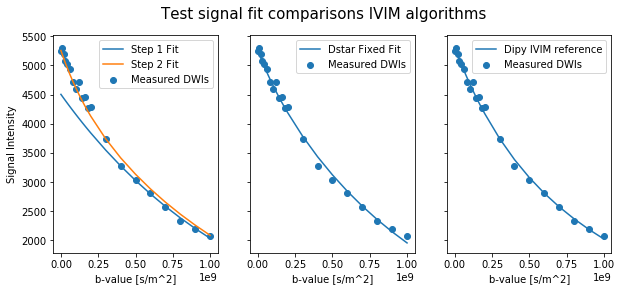

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(ncols=3, figsize=[10, 4], sharey=True)
fig.suptitle('Test signal fit comparisons IVIM algorithms', fontsize=15)
axs[0].set_ylabel('Signal Intensity')
axs[0].set_xlabel('b-value [s/m^2]')
axs[1].set_xlabel('b-value [s/m^2]')
axs[2].set_xlabel('b-value [s/m^2]')

axs[0].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[0].plot(scheme_ivim.bvalues, gaussian_fit.predict(scheme_ivim)[0], label='Step 1 Fit')
axs[0].plot(scheme_ivim.bvalues, ivim_fit_2step.predict()[0], label='Step 2 Fit')
axs[1].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[1].plot(scheme_ivim.bvalues, ivim_fit_Dfixed.predict()[0], label='Dstar Fixed Fit')
axs[2].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[2].plot(scheme_ivim.bvalues, ivim_fit_dipy.predict(gtab), label='Dipy IVIM reference')
for ax in axs:
    ax.legend()

## Parameter map comparison IVIM 2-step, Dstar_fixed, and Dipy reference

To properly evaluate the three algorithms we fit them to the same example slice as in the dipy IVIM example.

Note that in practice we can import custom (prepared) multi-compartment models directly:

In [20]:
from dmipy.custom_optimizers.intra_voxel_incoherent_motion import ivim_2step, ivim_Dstar_fixed
from time import time
ivim_fit_dmipy_2step = ivim_2step(scheme_ivim, data_slice)
ivim_fit_dmipy_fixed = ivim_Dstar_fixed(scheme_ivim, data_slice)
dipy_start = time()
ivim_fit_dipy = ivimmodel.fit(data_slice)
print('Dipy computation time: {} s'.format(time() - dipy_start))

Starting step 1 of IVIM 2-step algorithm.
Starting step 2 of IVIM 2-step algorithm.
Cannot estimate signal grid with voxel-dependent x0_vector.
IVIM 2-step optimization of 5200 voxels complete in 35.485 seconds
Starting IVIM Dstar-fixed algorithm.
IVIM Dstar-fixed optimization of 5200 voxels complete in 16.440 seconds
Dipy computation time: 149.582684994 s


We can then visualize the fitted parameter maps together:

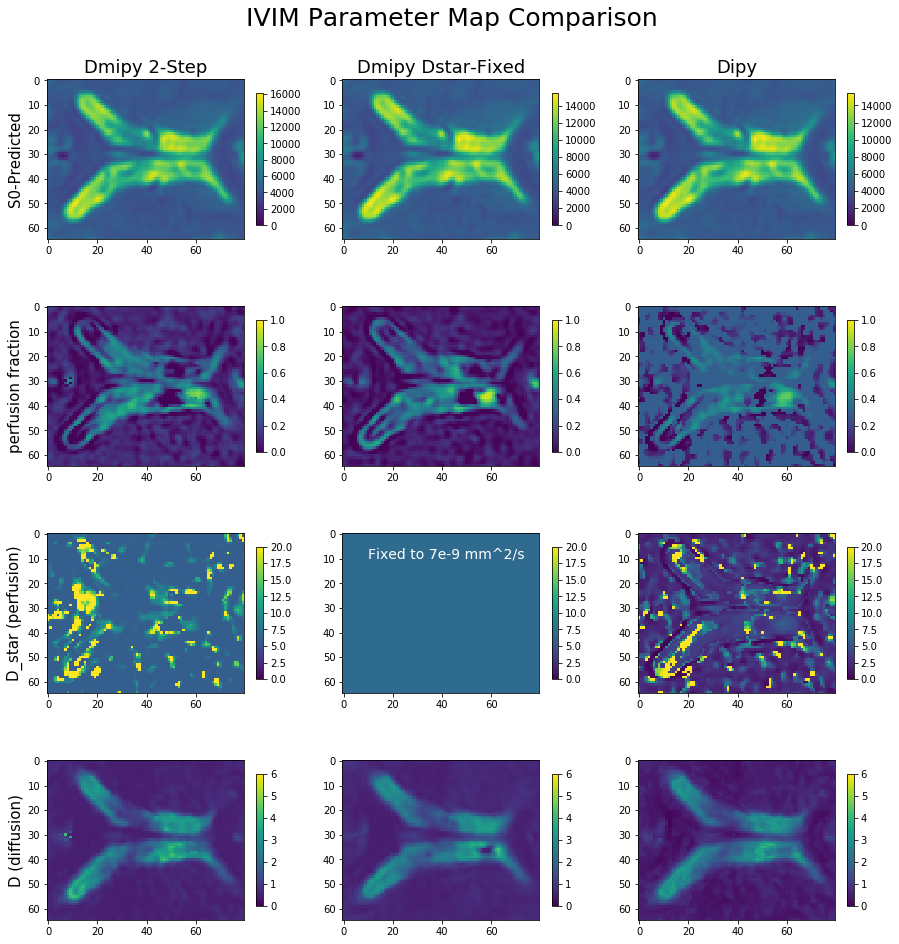

In [21]:
import numpy as np
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=[15, 16])
fig.suptitle('IVIM Parameter Map Comparison', fontsize=25, y=0.93)
axs = axs.ravel()
axs[0].set_title('Dmipy 2-Step', fontsize=18)
axs[1].set_title('Dmipy Dstar-Fixed', fontsize=18)
axs[2].set_title('Dipy', fontsize=18)
axs[0].set_ylabel('S0-Predicted', fontsize=15)
axs[3].set_ylabel('perfusion fraction', fontsize=15)
axs[6].set_ylabel('D_star (perfusion)', fontsize=15)
axs[9].set_ylabel('D (diffusion)', fontsize=15)

args = {'vmin': 0., 'interpolation': 'nearest'}
im0 = axs[0].imshow(ivim_fit_dmipy_2step.S0, **args)
im1 = axs[1].imshow(ivim_fit_dmipy_fixed.S0, **args)
im2 = axs[2].imshow(ivim_fit_dipy.S0_predicted, **args)
im3 = axs[3].imshow(ivim_fit_dmipy_2step.fitted_parameters['partial_volume_1'], vmax=1., **args)
im4 = axs[4].imshow(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'], vmax=1., **args)
im5 = axs[5].imshow(ivim_fit_dipy.perfusion_fraction, vmax=1., **args)
im6 = axs[6].imshow(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
im7 = axs[7].imshow(np.ones_like(ivim_fit_dmipy_2step.S0) * 
                    ivim_fit_dmipy_fixed.fitted_and_linked_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
axs[7].text(10, 10, 'Fixed to 7e-9 mm^2/s', fontsize=14, color='white')
im8 = axs[8].imshow(ivim_fit_dipy.D_star * 1e3, vmax=20, **args)
im9 = axs[9].imshow(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=6, **args)
im10 = axs[10].imshow(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=6, **args)
im11 = axs[11].imshow(ivim_fit_dipy.D * 1e3, vmax=6, **args)

for im, ax in zip([im0, im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

Notice that the 2 Dmipy algorithms perform very similarly, meaning that fixing Dstar apparently does not influence the optimized values of other values much (as expected, otherwise this would not be the finding of *(Gurney-Champion 2016)*.

Interestingly, the Dipy IVIM algorithm finds overall higher perfusion volume fractions than either Dmipy implementation, as well as extremely high D-star values outside of the optimization range.

Our findings become more clear in the following parameter histograms in the example slice:

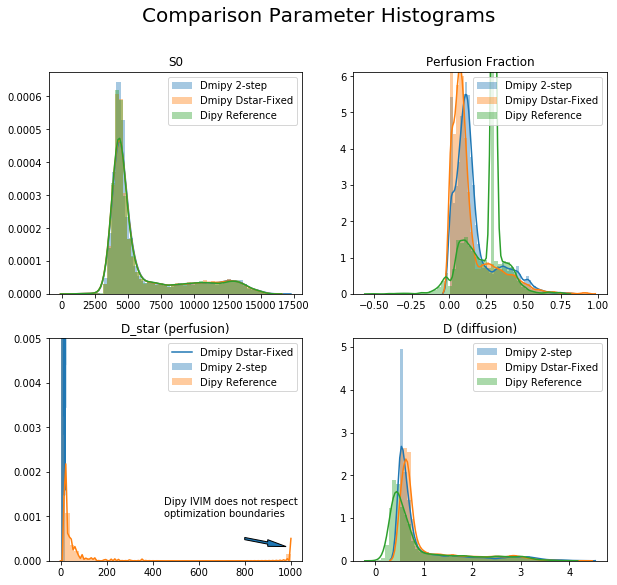

In [22]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=[10, 9])
fig.suptitle('Comparison Parameter Histograms', fontsize=20)
axs = axs.ravel()
sns.distplot(ivim_fit_dmipy_2step.S0.ravel(), ax=axs[0], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.S0.ravel(), ax=axs[0], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.S0_predicted.ravel(), ax=axs[0], label='Dipy Reference')
axs[0].set_title('S0')

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['partial_volume_1'].ravel(), ax=axs[1], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'].ravel(), ax=axs[1], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.perfusion_fraction.ravel(), ax=axs[1], label='Dipy Reference')
axs[1].set_title('Perfusion Fraction')

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_2_lambda_iso'].ravel() * 1e9, ax=axs[2], label='Dmipy 2-step')
axs[2].axvline(x=7, label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D_star.ravel() * 1e3, ax=axs[2], label='Dipy Reference')
axs[2].set_ylim(0, 0.005)
axs[2].set_title('D_star (perfusion)')
axs[2].text(450, 0.001, 'Dipy IVIM does not respect\noptimization boundaries')
axs[2].arrow(800, 0.0005, 100, -0.0001, width=0.00005, head_length=80.)

sns.distplot(ivim_fit_dmipy_2step.fitted_parameters['G1Ball_1_lambda_iso'].ravel() * 1e9, ax=axs[3], label='Dmipy 2-step')
sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'].ravel() * 1e9, ax=axs[3], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D.ravel() * 1e3, ax=axs[3], label='Dipy Reference')
axs[3].set_title('D (diffusion)')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

In the histograms notice again that the 2 Dmipy implementations find similar parameter values, and the Dipy implementation differs.
- S0 is basically the same for all algorithms.
- Perfusion fraction very similar for Dmipy IVIMs, and Dipy IVIM finds a very particular peak just above 0.25.
- D_star values for Dmipy fall within the optimization ranges, but it's impossible to see with the Dipy D_star values, which apparently sometimes find value sof 1000 (i.e. 3000 mm^2/s, 1000 times free water diffusivity).
- The regular D estimation for Dmipy IVIMs are very similar again, with Dipy IVIM being somewhat lower overall.

### Fitting error comparison

Following our previous findings we can also calculate the mean squared fitting error for the three algorithms.

In [23]:
mse_2step = ivim_fit_dmipy_2step.mean_squared_error(data_slice)
mse_Dstar_fixed = ivim_fit_dmipy_fixed.mean_squared_error(data_slice)
mse_dipy = np.mean(
    (ivim_fit_dipy.predict(gtab) / ivim_fit_dipy.S0_predicted[..., None] - 
     data_slice / ivim_fit_dipy.S0_predicted[..., None]) ** 2, axis=-1)

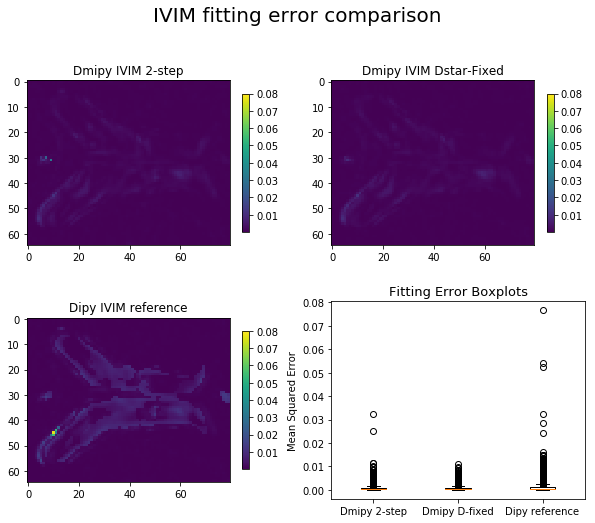

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[10, 8])
fig.suptitle('IVIM fitting error comparison', fontsize=20)
axs = axs.ravel()
im0 = axs[0].imshow(mse_2step, vmax=0.08)
im1 = axs[1].imshow(mse_Dstar_fixed, vmax=0.08)
im2 = axs[2].imshow(mse_dipy, vmax=0.08)

axs[0].set_title('Dmipy IVIM 2-step')
axs[1].set_title('Dmipy IVIM Dstar-Fixed')
axs[2].set_title('Dipy IVIM reference')

for im, ax in zip([im0, im1, im2], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

axs[3].boxplot(
    x=[mse_2step.ravel(), mse_Dstar_fixed.ravel(), mse_dipy.ravel()],
    labels=['Dmipy 2-step', 'Dmipy D-fixed', 'Dipy reference']);
axs[3].set_ylabel('Mean Squared Error')
axs[3].set_title('Fitting Error Boxplots', fontsize=13);

Notice that Dmipy 2-step and D-fixed have very similar fitting error, with 2-step having 2 outliers (local minima could possibly be avoided by increasing brute-force sampling rate Ns). The Dipy IVIM has significantly higher fitting error compared to the Dmipy IVIMs, even with some extreme outliers.

This example demonstrated that Dmipy can be easily used to generate, fit and evaluate differet IVIM implementations, and that it's performance is better and faster than the Dipy reference implementation at the moment of this writing.

#### References
- Le Bihan, D., Breton, E., Lallemand, D., Aubin, M. L., Vignaud, J., & Laval-Jeantet, M. (1988). Separation of diffusion and perfusion in intravoxel incoherent motion MR imaging. Radiology, 168(2), 497-505.
- Le Bihan, D. (2017). What can we see with IVIM MRI?. NeuroImage
- Gurney-Champion OJ, Froeling M, Klaassen R, Runge JH, Bel A, Van Laarhoven HWM, et al. Minimizing the Acquisition Time for Intravoxel Incoherent Motion Magnetic Resonance Imaging Acquisitions in the Liver and Pancreas. Invest Radiol. 2016;51: 211–220.
- Park HJ, Sung YS, Lee SS, Lee Y, Cheong H, Kim YJ, et al. Intravoxel incoherent motion diffusion-weighted MRI of the abdomen: The effect of fitting algorithms on the accuracy and reliability of the parameters. J Magn Reson Imaging. 2017;45: 1637–1647.
- Wong, S. M., Backes, W. H., Zhang, C. E., Staals, J., van Oostenbrugge, R. J., Jeukens, C. R. L. P. N., & Jansen, J. F. A. (2018). On the Reproducibility of Inversion Recovery Intravoxel Incoherent Motion Imaging in Cerebrovascular Disease. American Journal of Neuroradiology.
- Gurney-Champion, O. J., Klaassen, R., Froeling, M., Barbieri, S., Stoker, J., Engelbrecht, M. R., ... & Nederveen, A. J. (2018). Comparison of six fit algorithms for the intra-voxel incoherent motion model of diffusion-weighted magnetic resonance imaging data of pancreatic cancer patients. PloS one, 13(4), e0194590.